In [1]:
# A couple requried imports
from glob import glob 
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

# Importing the deep learning framework
from csbdeep.models import CARE, Config

from csbdeep.utils import plot_some, plot_history

Using TensorFlow backend.


# CSBDeep & Noise2Noise
We use the [CSBDeep](http://csbdeep.bioimagecomputing.com/) training framework which was published with [CARE](https://www.nature.com/articles/s41592-018-0216-7). Furthermore we use the [Noise2Noise](https://arxiv.org/abs/1803.04189) training principle first described by Lehtinen _et al._

# Load Data

Since I don't have any real data I am downloading one image. This image will serve as ground truth and we will add artifical noise to simulate noisy subs.

In [2]:
# Downloading an example image from wikimedia.
if len(glob('NGC_4051_hst_11661_G547.png')) == 0:
    !wget https://upload.wikimedia.org/wikipedia/commons/2/27/NGC_4051_hst_11661_G547.png

--2020-03-12 17:51:32--  https://upload.wikimedia.org/wikipedia/commons/2/27/NGC_4051_hst_11661_G547.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28086116 (27M) [image/png]
Saving to: ‘NGC_4051_hst_11661_G547.png’

NGC_4051_hst_11661_ 100%[===================>]  26.78M  29.5MB/s    in 0.9s    

2020-03-12 17:51:33 (29.5 MB/s) - ‘NGC_4051_hst_11661_G547.png’ saved [28086116/28086116]



In [3]:
# Load the image and make it gray-scale. 
# Note: Everything works also multi-channel, but will take longer.
gt = np.array(Image.open("NGC_4051_hst_11661_G547.png")).astype(np.float32)
gt = np.mean(gt/255.0, axis=-1)

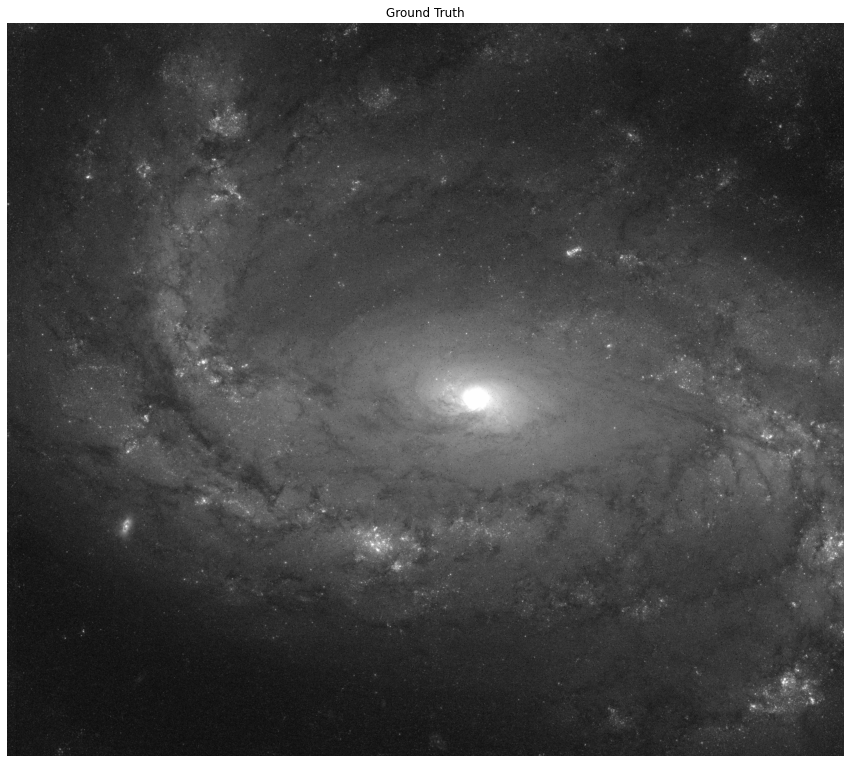

In [4]:
# Show the ground truth image
plt.figure(figsize=(15,15))
plt.imshow(gt, cmap='gray')
plt.axis('off');
plt.title('Ground Truth');
plt.show()

## Create Subs 

We scale the gt by 5 to get simulated average photon counts in the range [0, 5].

In [5]:
subs = []
for i in range(10):
    subs.append(np.random.poisson(gt * 5))
subs = np.array(subs)

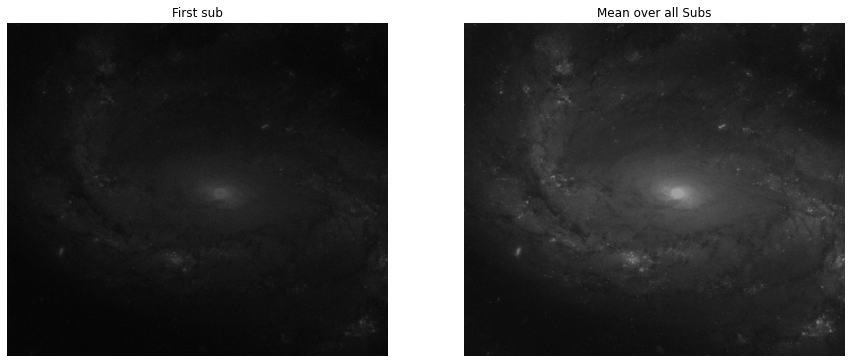

In [6]:
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(subs[0], cmap='gray')
plt.axis('off');
plt.title('First sub');
plt.subplot(1,2,2)
plt.imshow(np.sum(subs, axis=0), cmap='gray');
plt.axis('off');
plt.title('Mean over all Subs');
plt.show()

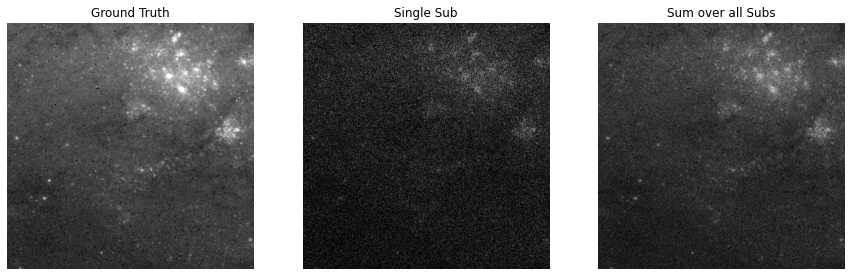

In [7]:
# Insets
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(gt[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Ground Truth');
plt.subplot(1,3,2)
plt.imshow(subs[0, 2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Single Sub');
plt.subplot(1,3,3)
plt.imshow(np.sum(subs, axis=0)[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Sum over all Subs');
plt.show()

# Prepare Training Data
From now on we only use the subs data.

__Note:__ Since this is a demo notebook we only have one image. You definitely want to use more images to train a proper network.

## Splitting the Subs
First we split the subs in two subsets.

In [8]:
# Split them in two halves.
even = np.sum(subs[::2], axis=0) # takes all subs with even index and sums them up
odd = np.sum(subs[1::2], axis=0) # takes all subs with odd index and sums them up

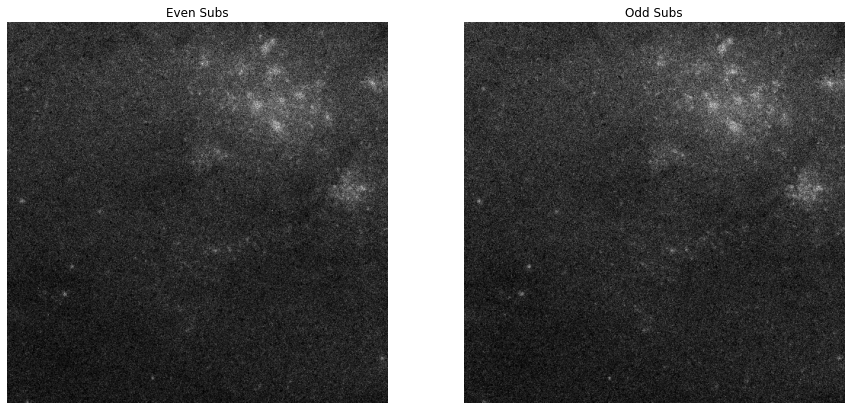

In [9]:
# Showing the inset of the even/odd subs
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(even[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Even Subs');
plt.subplot(1,2,2)
plt.imshow(odd[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Odd Subs');
plt.show()

### Generate Patches
Now we create patches from all (in this case one) training images. This is necessary, since GPUs have only limitted memory.

In [10]:
from csbdeep.data import RawData, create_patches

In [11]:
even_data = np.array([even])
odd_data = np.array([odd])

In [12]:
data = RawData.from_arrays(even_data, odd_data, axes='YX')

In [13]:
X, Y, _ = create_patches(data, patch_size=(64,64), n_patches_per_image=3500,
                               patch_filter=None, normalization=None)

    1 raw images x    1 transformations   =     1 images
    1 images     x 3500 patches per image =  3500 patches in total
Input data:
numpy array
Transformations:
1 x Identity
Patch size:
64 x 64


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


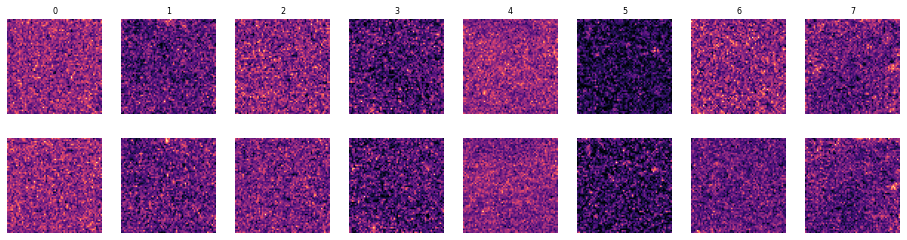

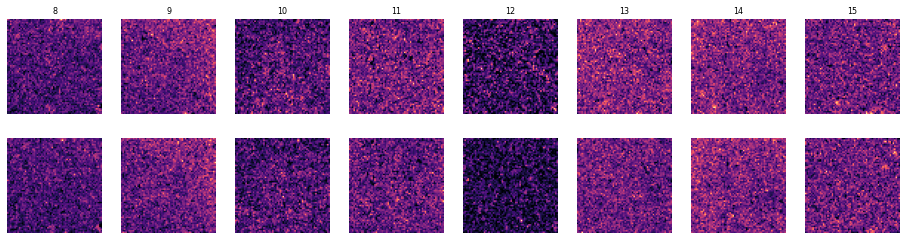

In [14]:
# Here we show a couple patches and can verify that they show the same content. 
# This is important. If there would be shifts, we would see them now. 
# The training only works if the images are perfectly registered. 
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;

## Create and Train the Network

In [15]:
# move channel to last axis (required for tensorflow)
X = np.moveaxis(X, 1, -1)
Y = np.moveaxis(Y, 1, -1)
print(X.shape, Y.shape)

(3500, 64, 64, 1) (3500, 64, 64, 1)


In [16]:
# Now we normalize the data to 0 mean and 1 standard deviation.
mean = np.mean(X)
std = np.std(X)
X = (X - mean)/std
Y = (Y - mean)/std

In [17]:
# We want to split the data into training and validation data.
# The network learns only from the training data and uses the validation
# data to prevent overfitting.

# 1. Shuffle the data
idx = np.random.permutation(X.shape[0])
X = X[idx]
Y = Y[idx]

# 2. Split into train and validation
val_fraction = int(0.1 * X.shape[0])
X_val = X[:val_fraction]
Y_val = Y[:val_fraction]
X = X[val_fraction:]
Y = Y[val_fraction:]
print(X.shape, Y.shape)
print(X_val.shape, Y_val.shape)

(3150, 64, 64, 1) (3150, 64, 64, 1)
(350, 64, 64, 1) (350, 64, 64, 1)


In [18]:
# Note: You want to increase train_epochs to something around 100-200. But you would require more data!
config = Config(axes='YXC', n_channel_in=1, n_channel_out=1, train_loss='mse', unet_kern_size=3,
               train_steps_per_epoch=200, train_epochs=30)
vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 30,
 'train_steps_per_epoch': 200,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

In [19]:
# Here we create a new model, which is called exmaple_model and stored in the directory 'models'.
model = CARE(config, name='example_model', basedir='models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [20]:
history = model.train(X, Y, (X_val, Y_val))


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/30
200/200 [==============================] - 11s 54ms/step - loss: 0.4979 - mse: 0.4979 - mae: 0.5475 - val_loss: 0.4843 - val_mse: 0.4843 - val_mae: 0.5403

Epoch 2/30
200/200 [==============================] - 3s 16ms/step - loss: 0.4615 - mse: 0.4615 - mae: 0.5293 - val_loss: 0.4803 - val_mse: 0.4803 - val_mae: 0.5396
Epoch 3/30
200/200 [==============================] - 3s 16ms/step - loss: 0.4580 - mse: 0.4580 - mae: 0.5275 - val_loss: 0.4789 - val_mse: 0.4789 - val_mae: 0.5373
Epoch 4/30
200/200 [==============================] - 3s 16ms/step - loss: 0.4576 - mse: 0.4576 - mae: 0.5273 - val_loss: 0.4784 - val_

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


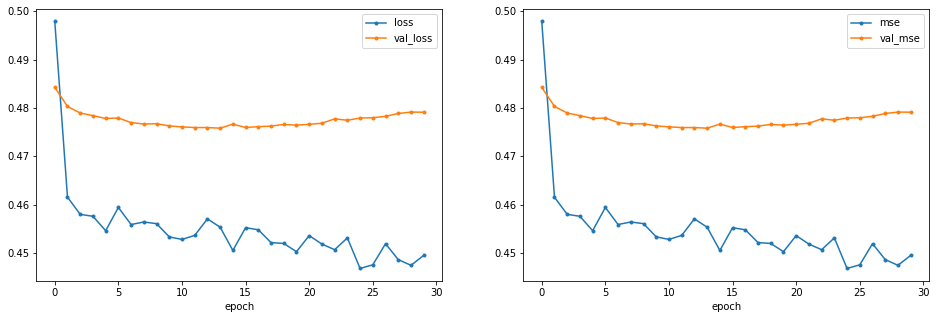

In [21]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse']);

## Predict

In [22]:
def normalize(img, mean, std):
    return (img - mean)/std

def denormalize(img, mean, std):
    return (img * std) + mean

In [23]:
even_pred = denormalize(model.predict(normalize(even, mean, std), axes='YX', normalizer=None), mean, std)

In [24]:
odd_pred = denormalize(model.predict(normalize(odd, mean, std), axes='YX', normalizer=None), mean, std)

In [25]:
denoised_img = (even_pred + odd_pred)/2.0

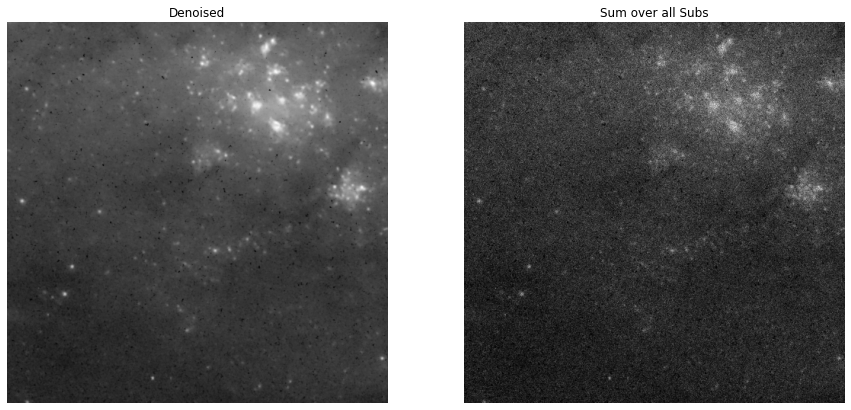

In [26]:
# Insets
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(denoised_img[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Denoised');
plt.subplot(1,2,2)
plt.imshow(np.sum(subs, axis=0)[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Sum over all Subs');
plt.show()

### Comparison to Ground Truth
Keep in mind that in reality you never know the ground truth image!

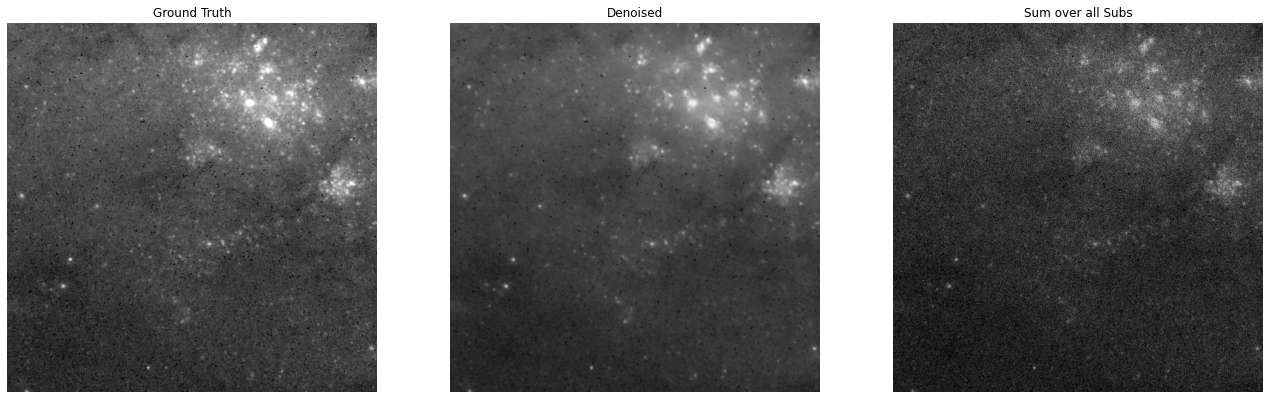

In [27]:
# Insets
plt.figure(figsize=(22.5,7.5))
plt.subplot(1,3,1)
plt.imshow(gt[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Ground Truth');
plt.subplot(1,3,2)
plt.imshow(denoised_img[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Denoised');
plt.subplot(1,3,3)
plt.imshow(np.sum(subs, axis=0)[2500:3000,1500:2000], cmap='gray')
plt.axis('off');
plt.title('Sum over all Subs');
plt.show()